## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

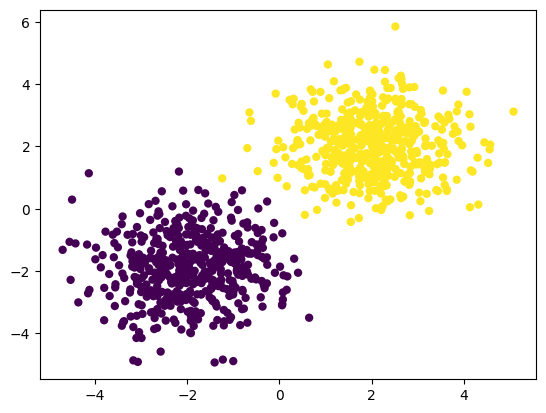

In [3]:
np.random.seed(42)

# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
#%reload_ext modules.ipynb
%run modules.ipynb

net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

#net = Sequential()
#net.add(Linear(2, 4))
#net.add(ReLU())
#net.add(Linear(4, 2))
#net.add(LogSoftMax())

#print(net)

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [3]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

In [77]:
np.random.seed(42)

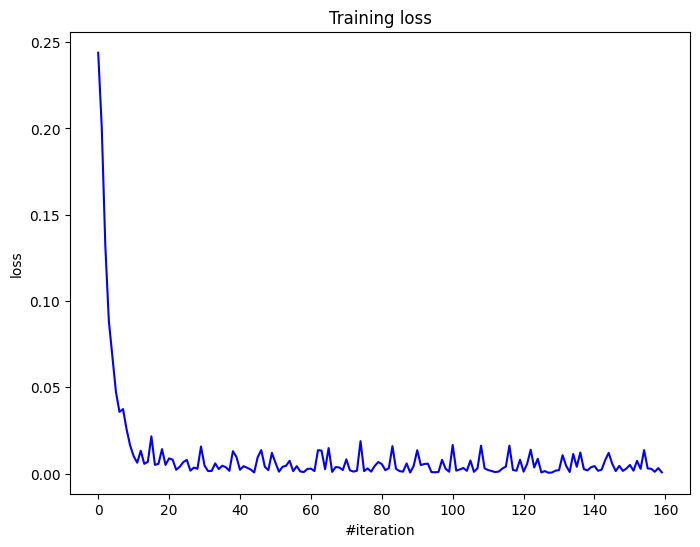

Current loss: 0.000682


In [78]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

In [79]:
W, b = net.getParameters()[0]
W = W.T
b = b.T
W, b

(array([[ 0.89927202, -2.23059097],
        [ 1.70332894, -1.38323121]]),
 array([-0.02952839,  0.15258785]))

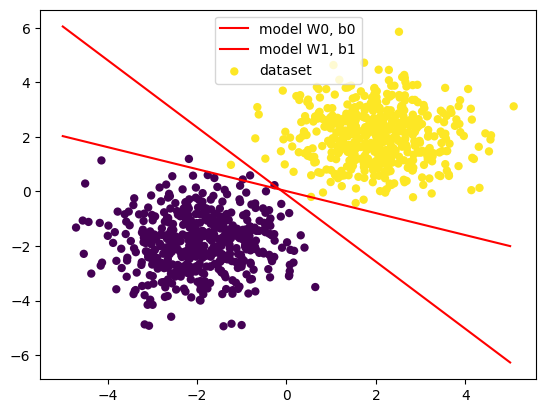

In [80]:
x = np.linspace(-5, 5, 10)
y1 = W[0][0]/W[0][1]*x+b[0]/W[0][1]
y2 = W[1][0]/W[1][1]*x+b[1]/W[1][1]

plt.plot(x, y1, 'r', label='model W0, b0')
plt.plot(x, y2, 'r', label='model W1, b1')
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none', label='dataset')

plt.legend()

**Now let's compare with torch**

In [81]:
from torch import nn
import torch
from torch.optim import SGD

In [82]:
model = nn.Sequential(
            nn.Linear(2,2),
            nn.LogSoftmax(dim=1),
        )
criterion = nn.NLLLoss()

optimizer = SGD(model.parameters(), lr=1e-1, momentum=0.9)

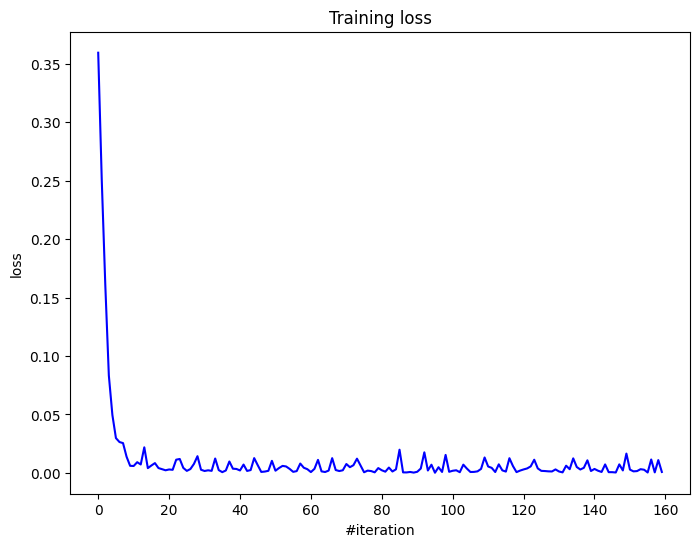

Current loss: 0.000830


In [83]:
loss_history = []

n_epoch = 20
for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):

        x_batch = torch.from_numpy(x_batch).float()
        y_batch = torch.from_numpy(y_batch)
        x_batch.requires_grad = True
        y_batch.requires_grad = True
        
        model.zero_grad()
        
        # Forward
        predictions = model.forward(x_batch)
        loss = criterion.forward(predictions, y_batch[:, -1].long())
    
        # Backward
        loss.backward()
        
        # Update weights
        optimizer.step()    
        
        loss_history.append(loss.item())

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

In [84]:
W, b = [p for p in model.parameters()]
W, b = W.detach().numpy(), b.detach().numpy()
W = W.T
b = b.T
W, b

(array([[ 1.8669691, -1.438168 ],
        [ 1.3296069, -2.0122223]], dtype=float32),
 array([-0.15872647, -0.051627  ], dtype=float32))

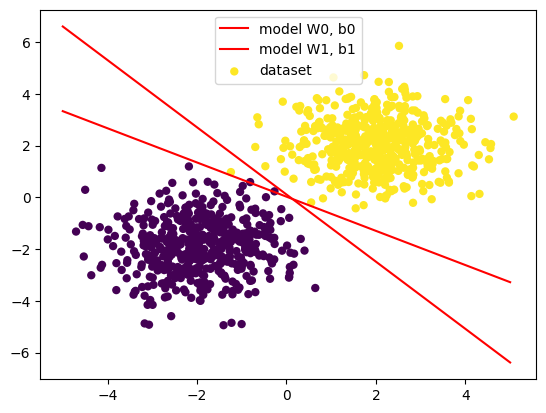

In [85]:
x = np.linspace(-5, 5, 10)
y1 = W[0][0]/W[0][1]*x+b[0]/W[0][1]
y2 = W[1][0]/W[1][1]*x+b[1]/W[1][1]

plt.plot(x, y1, 'r', label='model W0, b0')
plt.plot(x, y2, 'r', label='model W1, b1')
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none', label='dataset')

plt.legend()

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [4]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()
X_train.shape, X_val.shape, X_test.shape

((50000, 28, 28), (10000, 28, 28), (10000, 28, 28))

One-hot encode the labels first.

In [5]:
# Your code goes here. ################################################
def one_hot_encode(y, n_classes=10):
    y_one_hot = np.zeros((len(y), n_classes), dtype=float)
    y_one_hot[np.arange(len(y)), y.astype(int)] = 1.
    return y_one_hot

y_train = one_hot_encode(y_train)
y_val = one_hot_encode(y_val)
y_test = one_hot_encode(y_test)

In [6]:
def one_hot_decode(y, n_classes=10):
    y_decoded = (y * np.arange(n_classes)).sum(axis=-1)
    return y_decoded

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [7]:
X_train = X_train.reshape(X_train.shape[0], 28*28)
X_val = X_val.reshape(X_val.shape[0], 28*28)
X_test = X_test.reshape(X_test.shape[0], 28*28)
X_train.shape, y_train.shape

((50000, 784), (50000, 10))

**Comparison of activation fucntions**. No batchnorm after linear layers, no dropout. Only data normalization.

In [8]:
act_functions = {
    'ReLU': ReLU(),
    'LekyReLU': LeakyReLU(),
    'ELU': ELU(),
    'SotfPlus': SoftPlus(),
}

models = {}

for name, act_func in act_functions.items():
    model = Sequential()
    model.add(Linear(n_in=28*28, n_out=32*32))
    model.add(act_func)
    model.add(Linear(n_in=32*32, n_out=10))
    model.add(act_func)
    model.add(LogSoftMax())
    models[name] = model

criterion = ClassNLLCriterion()

In [9]:
optimizer_config_sgd = {'learning_rate' : 1e-3, 'momentum': 0.9} # sgd
optimizer_config_adam = {'learning_rate' : 1e-3, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-8} # for adam from paper

n_epoch = 20
batch_size = 1000

optimizer_state_sgd = {
    'ReLU': {},
    'LekyReLU': {},
    'ELU': {},
    'SotfPlus': {},
}

In [10]:
import time

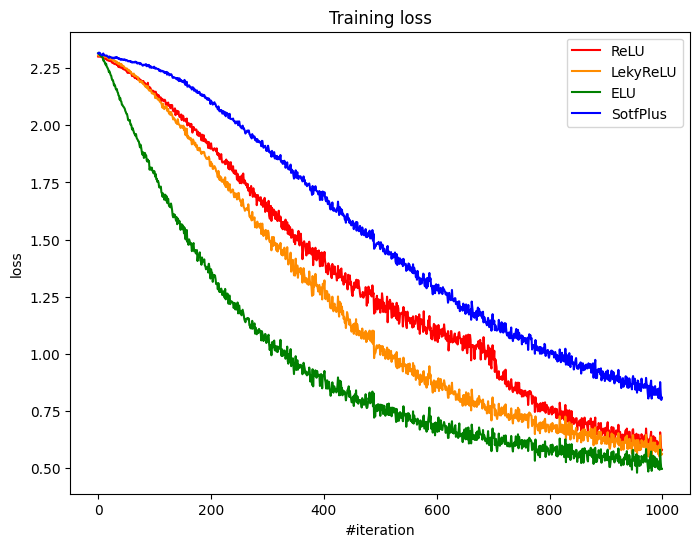

In [209]:
loss_history = {
    'ReLU': [],
    'LekyReLU': [],
    'ELU': [],
    'SotfPlus': [],
}

clrs = {
    'ReLU': 'red',
    'LekyReLU': 'darkorange',
    'ELU': 'green',
    'SotfPlus': 'blue',
}

times = {
    'ReLU': 0,
    'LekyReLU': 0,
    'ELU': 0,
    'SotfPlus': 0,
}

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        for name, model in models.items():
            
            t0 = time.time()

            model.zeroGradParameters()
            
            # Forward
            predictions = model.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            model.backward(x_batch, dp)
            
            # Update weights
            sgd_momentum(model.getParameters(), 
                        model.getGradParameters(), 
                        optimizer_config_sgd,
                        optimizer_state_sgd[name])

            dt = time.time() - t0

            times[name] += dt
            loss_history[name].append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    for name, model in models.items():
        plt.plot(loss_history[name], color=clrs[name], label=name)
    plt.legend()
    plt.show() 

Text(0, 0.5, 'Total time of training over 20')

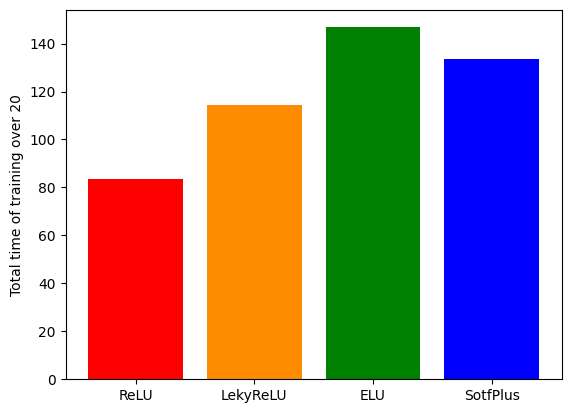

In [270]:
clrs = ['red', 'darkorange', 'green', 'blue',]

plt.bar(range(len(times)), list(times.values()), align='center', color=clrs)
plt.xticks(range(len(times)), list(times.keys()))
plt.ylabel('Total time of training over 20')

Now let's insert batchnorms between linear layers and activation function and compare performance

In [215]:
model_ReLU = Sequential()
model_ReLU.add(Linear(n_in=28*28, n_out=32*32))
model_ReLU.add(ReLU())
model_ReLU.add(Linear(n_in=32*32, n_out=10))
model_ReLU.add(ReLU())
model_ReLU.add(LogSoftMax())

model_BatchNorm = Sequential()
model_BatchNorm.add(Linear(n_in=28*28, n_out=32*32))
model_BatchNorm.add(BatchNormalization())
model_BatchNorm.add(ChannelwiseScaling(n_out=32*32))
model_BatchNorm.add(ReLU())
model_BatchNorm.add(Linear(n_in=32*32, n_out=10))
model_BatchNorm.add(BatchNormalization())
model_BatchNorm.add(ChannelwiseScaling(n_out=10))
model_BatchNorm.add(ReLU())
model_BatchNorm.add(LogSoftMax())

In [216]:
optimizer_config_sgd = {'learning_rate' : 1e-3, 'momentum': 0.9} # sgd
optimizer_config_adam = {'learning_rate' : 1e-3, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-8} # for adam from original paper

n_epoch = 30
batch_size = 1000

In [217]:
optimizer_state_sgd = {
    'ReLU': {},
    'ReLU+BatchNorm': {},
}

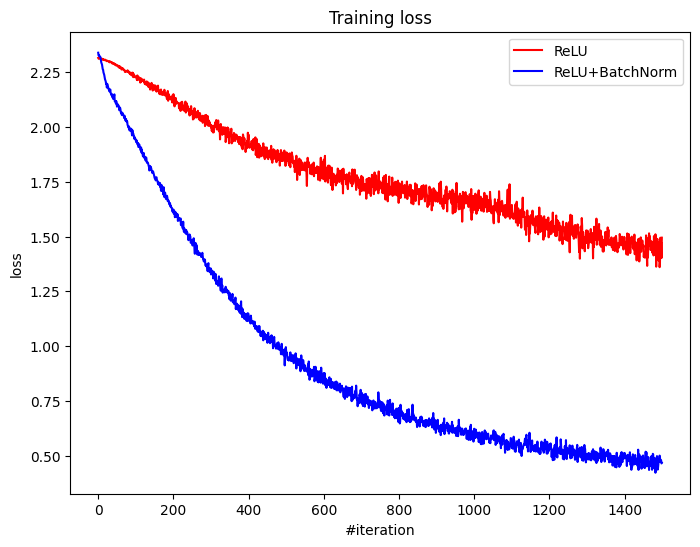

Current loss: 0.469369


In [117]:
loss_history = {
    'ReLU': [],
    'ReLU+BatchNorm': [],
}

names = ['ReLU', 'ReLU+BatchNorm']
clrs = ['red', 'blue']

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        for name, model in zip(names, [model_ReLU, model_BatchNorm]): 

            model.zeroGradParameters()
            
            # Forward
            predictions = model.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
        
            # Backward
            dp = criterion.backward(predictions, y_batch)
            model.backward(x_batch, dp)
            
            # Update weights
            sgd_momentum(model.getParameters(), 
                        model.getGradParameters(), 
                        optimizer_config_sgd,
                        optimizer_state_sgd[name])

            '''adam_optimizer(model.getParameters(), 
                        model.getGradParameters(), 
                        optimizer_config_adam,
                        optimizer_state_adam)'''
            
            loss_history[name].append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    for name, clr in zip(names, clrs):
        plt.plot(loss_history[name], color=clr, label=name)
    plt.legend()
    plt.show()
    
    print('Current loss: %f' % loss)    

Yeah, the training is going way faster. Let's have a look on different optimizers

In [103]:
def get_model():
    model_BatchNorm = Sequential()
    model_BatchNorm.add(Linear(n_in=28*28, n_out=32*32))
    model_BatchNorm.add(BatchNormalization())
    model_BatchNorm.add(ChannelwiseScaling(n_out=32*32))
    model_BatchNorm.add(ReLU())
    model_BatchNorm.add(Linear(n_in=32*32, n_out=10))
    model_BatchNorm.add(BatchNormalization())
    model_BatchNorm.add(ChannelwiseScaling(n_out=10))
    model_BatchNorm.add(ReLU())
    model_BatchNorm.add(LogSoftMax())
    return model_BatchNorm

# Initialize models with the same parameters

model_1 = get_model()
#model_2 = get_model()

from copy import deepcopy

model_2 = deepcopy(model_1)
#model_2.modules.pop(-2)

In [104]:
model_1 is model_2, model_1 == model_2

(False, False)

In [105]:
model_1.modules, model_2.modules

([Linear 784 -> 1024,
  BatchNormalization,
  ChannelwiseScaling,
  ReLU,
  Linear 1024 -> 10,
  BatchNormalization,
  ChannelwiseScaling,
  ReLU,
  LogSoftMax],
 [Linear 784 -> 1024,
  BatchNormalization,
  ChannelwiseScaling,
  ReLU,
  Linear 1024 -> 10,
  BatchNormalization,
  ChannelwiseScaling,
  ReLU,
  LogSoftMax])

In [106]:
model_1.modules[0].getParameters()[0] == model_2.modules[0].getParameters()[0]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [107]:
state_sgd = {}
state_Adam = {}

criterion_1 = ClassNLLCriterion()
criterion_2 = ClassNLLCriterion()

n_epoch = 30
batch_size = 1000

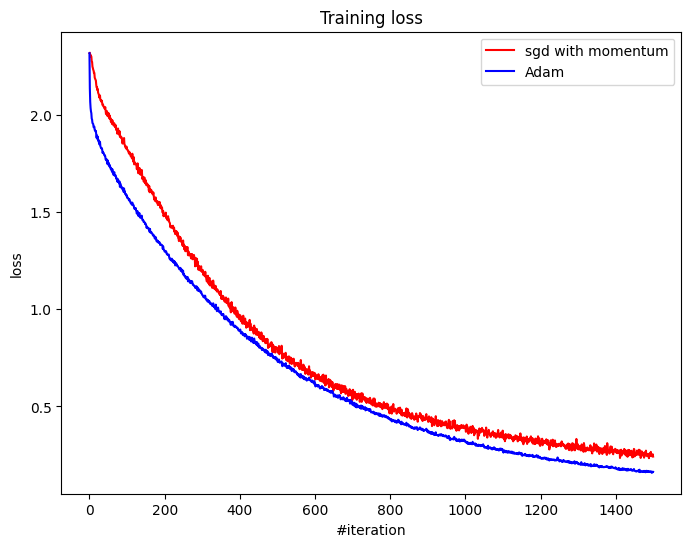

Current losses: 0.24233 0.16383


In [108]:
loss_history = {
    'sgd with momentum': [],
    'Adam': [],
}

names = ['sgd with momentum', 'Adam']
clrs = ['red', 'blue']

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size): 

        model_1.zeroGradParameters()
        model_2.zeroGradParameters()
        
        # Forward
        predictions_1 = model_1.forward(x_batch)
        loss_1 = criterion_1.forward(predictions_1, y_batch)

        predictions_2 = model_2.forward(x_batch)
        loss_2 = criterion_2.forward(predictions_2, y_batch)
    
        # Backward
        dp1 = criterion_1.backward(predictions_1, y_batch)
        model_1.backward(x_batch, dp1)

        dp2 = criterion_2.backward(predictions_2, y_batch)
        model_2.backward(x_batch, dp2)
        
        # Update weights
        sgd_momentum(model_1.getParameters(), 
                    model_1.getGradParameters(), 
                    optimizer_config_sgd,
                    state_sgd)

        adam_optimizer(model_2.getParameters(), 
                    model_2.getGradParameters(), 
                    optimizer_config_adam,
                    state_Adam)
        
        loss_history['sgd with momentum'].append(loss_1)
        loss_history['Adam'].append(loss_2)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    for name, clr in zip(names, clrs):
        plt.plot(loss_history[name], color=clr, label=name)
    plt.legend()
    plt.show()
    
    print('Current losses: %0.5f %0.5f' % (loss_1, loss_2))

In [110]:
loss_history['sgd with momentum'][:3], loss_history['Adam'][:3]

([2.318138261656565, 2.320558976639805, 2.3089979850964757],
 [2.318138261656565, 2.139104745328996, 2.0677209176935385])

In case of Adam `loss` dropped a bit lower. It also dropped more decently over first few steps

Performing the final training of a complex model

In [11]:
# Your code goes here. ################################################
model_MNIST = Sequential()

model_MNIST.add(Linear(n_in=28*28, n_out=32*32))
model_MNIST.add(LeakyReLU())
model_MNIST.add(BatchNormalization())
model_MNIST.add(ChannelwiseScaling(n_out=32*32))

model_MNIST.add(Linear(n_in=32*32, n_out=32*32))
model_MNIST.add(LeakyReLU())
model_MNIST.add(BatchNormalization())
model_MNIST.add(ChannelwiseScaling(n_out=32*32))

model_MNIST.add(Linear(n_in=32*32, n_out=10))
model_MNIST.add(BatchNormalization())
model_MNIST.add(ChannelwiseScaling(n_out=10))
model_MNIST.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(model_MNIST)

Linear 784 -> 1024
LeakyReLU
BatchNormalization
ChannelwiseScaling
Linear 1024 -> 1024
LeakyReLU
BatchNormalization
ChannelwiseScaling
Linear 1024 -> 10
BatchNormalization
ChannelwiseScaling
LogSoftMax



In [12]:
optimizer_config_adam = {'learning_rate' : 1e-4, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-8} # for adam from paper
optimizer_state_adam = {}

n_epoch = 30
batch_size = 128

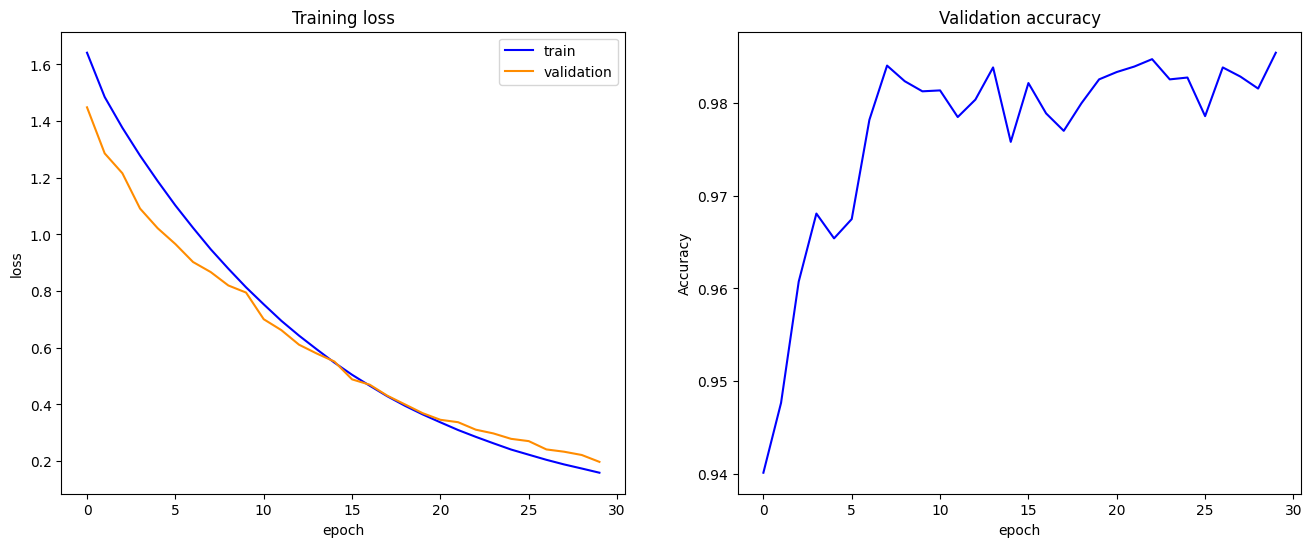

In [13]:
loss_history = []
loss_history_val = []
val_accuracy = []

for i in range(n_epoch):

    loss_ep = []
    loss_ep_val = []
    val_acc = []

    model_MNIST.train()
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):

        model_MNIST.zeroGradParameters()
        
        # Forward
        predictions = model_MNIST.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        model_MNIST.backward(x_batch, dp)
        
        # Update weights
        adam_optimizer(model_MNIST.getParameters(), 
                     model_MNIST.getGradParameters(), 
                     optimizer_config_adam,
                     optimizer_state_adam)
        
        loss_ep.append(loss)

    model_MNIST.evaluate()
    for x_batch, y_batch in get_batches((X_val, y_val), batch_size):
        predictions_val = model_MNIST.forward(x_batch)
        loss_val = criterion.forward(predictions_val, y_batch)
        loss_ep_val.append(loss_val)

        y_pred = np.exp(predictions_val).argmax(axis=-1)
        acc = (y_pred == one_hot_decode(y_batch)).mean()
        val_acc.append(acc)

    loss_history.append(np.mean(loss_ep))
    loss_history_val.append(np.mean(loss_ep_val))
    val_accuracy.append(np.mean(val_acc))

    # Visualize
    display.clear_output(wait=True)
    fig, ax = plt.subplots(1,2, figsize=(16, 6))
        
    ax[0].set_title("Training loss")
    ax[0].set_xlabel("epoch")
    ax[0].set_ylabel("loss")
    ax[0].plot(loss_history, 'b', label='train')
    ax[0].plot(loss_history_val, 'darkorange', label='validation')
    ax[0].legend()

    ax[1].set_title('Validation accuracy')
    ax[1].set_xlabel("epoch")
    ax[1].set_ylabel("Accuracy")
    ax[1].plot(val_accuracy, color='b')

    plt.show()  

In [20]:
test_accuracy = []

for X_batch, y_batch in get_batches((X_test, y_test), batch_size):
    predictions_test = model_MNIST.forward(X_batch)
    y_pred = predictions_test.argmax(axis=-1)
    accuracy = (y_pred == one_hot_decode(y_batch)).mean()
    test_accuracy.append(accuracy)

test_acc = np.mean(test_accuracy)
print(f'Test accuracy is {test_acc:0.3f}')

Test accuracy is 0.984


**Well, everything works quite good. The model is not overfitted and accuracy is high on both validation and test data**

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

# Your answer goes here. ################################################

$\color{blue}{\text{1) Activation functions with exp obviously take more time to be calculated}}$

$\color{blue}{\text{2) BatchNormalization helps a lot. It can be seen from the graph above}}$

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [ ]:
# Your code goes here. ################################################

**CHECK IT HIGHER**

Print here your accuracy on test set. It should be around 90%.

In [ ]:
# Your answer goes here. ################################################

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [ ]:
# Your beautiful code here.

In [83]:
import torch
from torch import nn
from torch.optim import Adam

import time

In [84]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [85]:
def train_model(model, train_set, val_set, loss_fn, opt, n_epochs: int):
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in get_batches(train_set, batch_size):
            # move data to target device
            ### YOUR CODE HERE
            X_batch = torch.from_numpy(X_batch).to(device, torch.float32)
            y_batch = torch.from_numpy(y_batch).to(device, torch.long)
            X_batch.requires_grad = True
            #y_batch.requires_grad = True

            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            ### YOUR CODE HERE
            model.zero_grad()

            predictions = model(X_batch)
            loss = loss_fn.forward(input=predictions, target=y_batch)
            loss.backward()
            opt.step()

            ep_train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in get_batches(val_set, batch_size):
                # move data to target device
                ### YOUR CODE HERE
                X_batch = torch.from_numpy(X_batch).to(device, torch.float32)
                y_batch = torch.from_numpy(y_batch).to(device, torch.long)
                # compute predictions
                ### YOUR CODE HERE
                predictions_val = model(X_batch)
                ep_val_loss.append(loss_fn(input=predictions_val, target=y_batch).item())
                y_pred = predictions_val.max(axis=-1).indices ### YOUR CODE HERE
                accuracy = (y_pred == y_batch).detach().cpu().numpy().mean()
                ep_val_accuracy.append(accuracy)

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

In [86]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

In [98]:
class MyNN(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 32*32),
            nn.LeakyReLU(),
            nn.BatchNorm1d(num_features=32*32),
            nn.Linear(32*32, 32*32),
            nn.LeakyReLU(),
            nn.BatchNorm1d(num_features=32*32),
            nn.Linear(32*32, num_classes),
            nn.BatchNorm1d(num_features=num_classes),
        )
        
    def forward(self, inp):       
        return self.model(inp)
        out =  self.model(inp)

In [99]:
model = MyNN().to(device)
opt = Adam(params=model.parameters(), lr=1e-4,) #eps=1e-8, betas=(0.9, 0.999), weight_decay=0.99) # YOUR CODE HERE
loss_func = nn.CrossEntropyLoss()

In [100]:
import mnist

X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()
y_train_eval = y_train.copy()
X_train.shape, X_val.shape, X_test.shape

((50000, 28, 28), (10000, 28, 28), (10000, 28, 28))

In [101]:
n_epochs = 30

batch_size = 128
train_loss, val_loss, val_accuracy = train_model(model, (X_train, y_train), (X_val, y_val), loss_func, opt, n_epochs)

Epoch 1 of 30 took 1.964s
	  training loss: 0.582273
	validation loss: 0.413007
	validation accuracy: 0.971
Epoch 2 of 30 took 1.535s
	  training loss: 0.402770
	validation loss: 0.350674
	validation accuracy: 0.977
Epoch 3 of 30 took 1.672s
	  training loss: 0.343722
	validation loss: 0.312573
	validation accuracy: 0.983
Epoch 4 of 30 took 1.578s
	  training loss: 0.300379
	validation loss: 0.290697
	validation accuracy: 0.983
Epoch 5 of 30 took 1.670s
	  training loss: 0.264080
	validation loss: 0.275570
	validation accuracy: 0.984
Epoch 6 of 30 took 1.612s
	  training loss: 0.235588
	validation loss: 0.250998
	validation accuracy: 0.985
Epoch 7 of 30 took 1.534s
	  training loss: 0.213509
	validation loss: 0.234173
	validation accuracy: 0.984
Epoch 8 of 30 took 1.496s
	  training loss: 0.190889
	validation loss: 0.218867
	validation accuracy: 0.986
Epoch 9 of 30 took 1.484s
	  training loss: 0.172092
	validation loss: 0.204132
	validation accuracy: 0.986
Epoch 10 of 30 took 1.503s
	

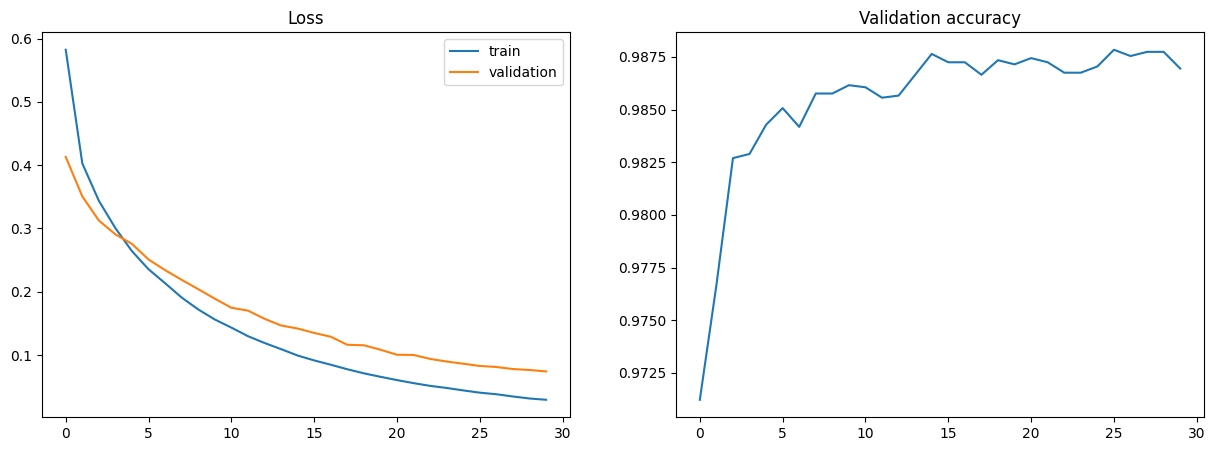

In [102]:
plot_train_process(train_loss, val_loss, val_accuracy)

Yo, very good model. Now, let's check accuracy on `X_test`

In [103]:
test_accuracy = []

with torch.no_grad():
    for X_batch, y_batch in get_batches((X_test, y_test), batch_size):
        X_batch = torch.from_numpy(X_batch).to(device, torch.float32)
        y_batch = torch.from_numpy(y_batch).to(device, torch.long)
        predictions_val = model(X_batch)
        y_pred = predictions_val.max(axis=-1).indices
        accuracy = (y_pred == y_batch).detach().cpu().numpy().mean()
        test_accuracy.append(accuracy)

test_acc = np.mean(test_accuracy)
print(f'Test accuracy is {test_acc:0.3f}')

Test accuracy is 0.987


Also very high. So, everything is similar to my `numpy` implementation and that's cool